# PRODUCTS

**A. CLEAN UP AND PREPARE PRODUCT DATA**

A.1 Load and plot

In [111]:
%matplotlib inline
import pandas as pd

import matplotlib.pyplot as plt

import os

# pip install fuzzywuzzy
from fuzzywuzzy import fuzz

from operator import itemgetter

import re

#Website object lists : https://7esl.com/tools-and-equipment/#Technological_Gadgets

In [112]:
os.getcwd()

'/Users/lou/Documents/Travail/master 2/ADA/epfl-ada-2019-project-bubble582/code'

In [336]:
#load the data
hh_demographic = pd.read_csv('../data/dunnhumby_complete_csv/hh_demographic.csv', sep = ',')

transaction_data = pd.read_csv('../data/dunnhumby_complete_csv/transaction_data.csv', sep = ',')

product = pd.read_csv('../data/dunnhumby_complete_csv/product.csv', sep = ',')

FoodLabels = pd.read_csv('../data/dunnhumby_complete_csv/FoodLabelsV3.csv', sep = ',')

ObjectLabels = pd.read_csv('../data/dunnhumby_complete_csv/GroceryLists.csv', sep = ',')

ObjectLabels.columns = ['ITEM','LABEL']

In [4]:
product.head(4)

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ


First we get interested by the different departments in the commercial center. We reorder the departments and plot the number of products we can find per department. 

In [5]:
# REORDERING PART
ordered_manufacturer= product.MANUFACTURER.astype(int).sort_values()
ordered_manufacturer= ordered_manufacturer.unique()

product['MANUFACTURER'] = pd.Categorical(product['MANUFACTURER'],
                      ordered = True,
                      categories = ordered_manufacturer)

print ('The order of the manufacturer categories is :', ordered_manufacturer)

The order of the manufacturer categories is : [   1    2    3 ... 6475 6476 6477]


In [6]:
ordered_department= ['GROCERY','FROZEN GROCERY','GRO BAKERY','PASTRY',
        'SEAFOOD','SEAFOOD-PCKGD','MEAT', 'MEAT-PCKGD','MEAT-WHSE','PORK','SPIRITS','NUTRITION',
       'PRODUCE','CHEF SHOPPE','RESTAURANT','SALAD BAR','DELI', 'DAIRY DELI','DELI/SNACK BAR',
    'DRUG GM','COSMETICS','PHARMACY SUPPLY','GARDEN CENTER','FLORAL', 'TRAVEL & LEISUR', 
    'POSTAL CENTER', 'PHOTO', 'VIDEO','VIDEO RENTAL','TOYS','HOUSEWARES', 
    'KIOSK-GAS', 'ELECT &PLUMBING','AUTOMOTIVE','GM MERCH EXP','COUP/STR & MFG', 
     'CHARITABLE CONT', 'RX','PROD-WHS SALES', 'HBC','CNTRL/STORE SUP','MISC. TRANS.', 'MISC SALES TRAN',' ']

product['DEPARTMENT'] = pd.Categorical(product['DEPARTMENT'],
                      ordered = True,
                      categories = ordered_department)

print ('The order of the department categories is :', ordered_department)

The order of the department categories is : ['GROCERY', 'FROZEN GROCERY', 'GRO BAKERY', 'PASTRY', 'SEAFOOD', 'SEAFOOD-PCKGD', 'MEAT', 'MEAT-PCKGD', 'MEAT-WHSE', 'PORK', 'SPIRITS', 'NUTRITION', 'PRODUCE', 'CHEF SHOPPE', 'RESTAURANT', 'SALAD BAR', 'DELI', 'DAIRY DELI', 'DELI/SNACK BAR', 'DRUG GM', 'COSMETICS', 'PHARMACY SUPPLY', 'GARDEN CENTER', 'FLORAL', 'TRAVEL & LEISUR', 'POSTAL CENTER', 'PHOTO', 'VIDEO', 'VIDEO RENTAL', 'TOYS', 'HOUSEWARES', 'KIOSK-GAS', 'ELECT &PLUMBING', 'AUTOMOTIVE', 'GM MERCH EXP', 'COUP/STR & MFG', 'CHARITABLE CONT', 'RX', 'PROD-WHS SALES', 'HBC', 'CNTRL/STORE SUP', 'MISC. TRANS.', 'MISC SALES TRAN', ' ']


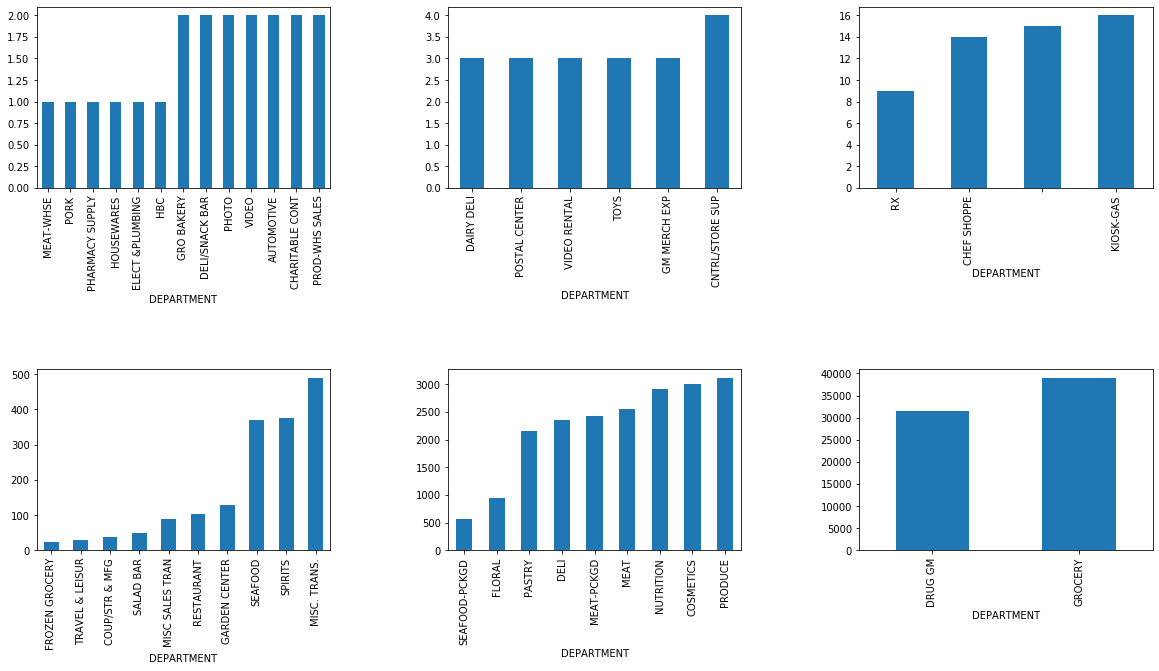

In [7]:
department= product.groupby(['DEPARTMENT']).count()

#PLOT THE NUMBER OF PRODUCTS PER DEPARTMENT

fig = plt.figure(figsize=(20,10))

# Divide the figure into a 2x1 grid, and give me the first section
ax1 = fig.add_subplot(231)

# Divide the figure into a 2x1 grid, and give me the second section
ax2 = fig.add_subplot(232)

ax3 = fig.add_subplot(233)

ax4 = fig.add_subplot(234)

ax5 = fig.add_subplot(235)

ax6 = fig.add_subplot(236)

department[(department.BRAND>0) & (department.BRAND<=2)].BRAND.sort_values().plot.bar(ax=ax1)
department[(department.BRAND>2) & (department.BRAND<=5)].BRAND.sort_values().plot.bar(ax=ax2)
department[(department.BRAND>5) & (department.BRAND<=20)].BRAND.sort_values().plot.bar(ax=ax3)
department[(department.BRAND>20) & (department.BRAND<=500)].BRAND.sort_values().plot.bar(ax=ax4)
department[(department.BRAND>500) & (department.BRAND<=4000)].BRAND.sort_values().plot.bar(ax=ax5)
department[department.BRAND>4000].BRAND.sort_values().plot.bar(ax=ax6)

fig.subplots_adjust(hspace=1)
fig.subplots_adjust(wspace=0.4)


As we can see in the previous barplots, the departments with the highest number of referenced products in this study are the grocery with almost 40000 products, and the drug GM (which is probably a drug store) with more than 30000 products. We are going to focus on these 2 mains stores in a first time.

**A. GROCERY DATA PREPROCESSING**

In this part we are interested to clean up and categorize the different products from the grocery store. We want to explain what purpose they serve (food, sanitary & hygien products, pet products). We create a special Grocery dataframe for this purpose.

In [8]:
#we extract the grocery product data which is the main supermarket in the commercial center
Grocery= pd.DataFrame(product[product['DEPARTMENT'] == 'GROCERY'])
Grocery.head()

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ
5,26426,69,GROCERY,Private,SPICES & EXTRACTS,SPICES & SEASONINGS,2.5 OZ
6,26540,69,GROCERY,Private,COOKIES/CONES,TRAY PACK/CHOC CHIP COOKIES,16 OZ


The only product descriptions provided by the Grocery data are few words descriptions found in COMMODITY_DESC and SUB_COMMODITY_DESC columns. These descriptions are not standardized, no categories arise from them. 

In a first time, we want to categorize the description words using different labels (produce, households, technology ...). To do so we create a function called "LabelizeProduct". This function first recognizes the different words or words sequences in the description. These words or words sequences are associated with a certain label in a list of shopping items ("GroceryList.csv"). In a second time, based on the fuzzywuzzy librairy, the "LabelizeProduct" gives a score with comparing the description and the shopping item corresponding to words sequence identified. Finally, the functions keep the label for which the score is the highest. 

In [259]:
# This function is able to categorize the products given in data with looking at a labelled list of words. 
#This labelled list of words is a lexique of grocery and shopping words. The threshold is the smallest 
#fuzzywuzzy score accepted to declare a match. (fuzzywuzzy gives a score of string matching over 100 )
def LabelizeProduct(data, dataCol, threshold) :
    
    Out = pd.DataFrame(index = data.index, columns = ['Item','Ratio','Label'])
    
    loopCounter = 0
    for indexCOM in data.index :
        
        if (loopCounter%100 == 0): 
            print(loopCounter)
        
        item = dataCol.loc[indexCOM]
        match = []

        Out.Item[indexCOM] = item
        Out.Label[indexCOM] = 'not found'
        Out.Ratio[indexCOM]= 0

        for index,label in enumerate(ObjectLabels['LABEL']) :

            line = re.split(' |&|/',ObjectLabels.ITEM[index])

            for word in line:
                lword= word.lower()
                litem = item.lower()


                if litem.find(lword)!= -1:
                    ratio = fuzz.token_sort_ratio(str.lower(item), str.lower(lword))
                    match.append((indexCOM,line,ratio,label))
                    
        if (match) and (max(match,key=itemgetter(2))[2]>= threshold)  :
            Out.Label[indexCOM] = max(match,key=itemgetter(2))[3]
            Out.Ratio[indexCOM]= max(match,key=itemgetter(2))[2]
            
        loopCounter += 1
            
    return Out

In [337]:
LabelledSUB = LabelizeProduct(Grocery, Grocery.SUB_COMMODITY_DESC, 0)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [338]:
Labelled = LabelizeProduct(Grocery, Grocery.COMMODITY_DESC, 0) 

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [339]:
Labelled['RatioSUB']= LabelledSUB.Ratio
Labelled['LabelSUB']= LabelledSUB.Label

In [312]:
Labelled.head(10)

,Item,Ratio,Label,RatioSUB,LabelSUB
0,FRZN ICE,67,FROZEN,30,FAST FOOD & SNACKS
3,FRUIT - SHELF STABLE,0,not found,62,PRODUCE
4,COOKIES/CONES,63,FAST FOOD & SNACKS,52,FAST FOOD & SNACKS
5,SPICES & EXTRACTS,50,SPICE/HERBS,45,SPICE/HERBS
6,COOKIES/CONES,63,FAST FOOD & SNACKS,36,FAST FOOD & SNACKS
9,PNT BTR/JELLY/JAMS,43,BAKERY,100,FAST FOOD & SNACKS
10,ICE CREAM/MILK/SHERBTS,37,FAST FOOD & SNACKS,0,not found
12,ICE CREAM/MILK/SHERBTS,37,FAST FOOD & SNACKS,0,not found
13,AIR CARE,67,HOUSEHOLDS,38,HOUSEHOLDS
14,ICE CREAM/MILK/SHERBTS,37,FAST FOOD & SNACKS,0,not found


In [296]:
Grocery['Label'] = 'none'

# this is the function that put the Labels in the main data Table. It compares the labels and fuzzy scores for 
# COMMODITY and SUB_COMMODITY labelled data and chooses the best one. 
def putLabel(LabelledData, data) :
    for line in LabelledData.index : 

        maxRatio = max(LabelledData.Ratio.loc[line],LabelledData.RatioSUB.loc[line])
        if LabelledData.Ratio.loc[line] == maxRatio :
            data['Label'].loc[line] = LabelledData.Label.loc[line]
        elif LabelledData.RatioSUB.loc[line] == maxRatio :
            data['Label'].loc[line] = LabelledData.LabelSUB.loc[line]
    return 0

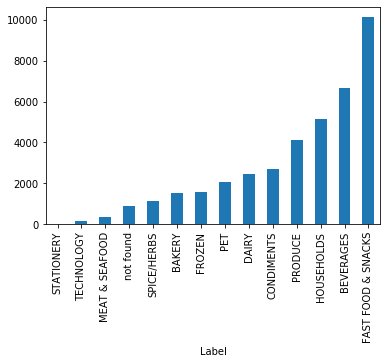

In [340]:
putLabel(Labelled, Grocery)
LabelCount= Grocery.groupby('Label').count()

LabelCount.BRAND.sort_values().plot.bar()

In [341]:
Grocery.to_csv('Grocery.csv')

In [342]:
Grocery[Grocery.Label == 'not found'].head(60)

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT,Label
74,28304,69,GROCERY,Private,SOUP,CONDENSED SOUP,10.75 OZ,not found
133,30491,69,GROCERY,Private,SOUP,CONDENSED SOUP,26 OZ,not found
293,35506,1251,GROCERY,National,SOUP,CONDENSED SOUP,10 3/4 OZ,not found
327,36723,1251,GROCERY,National,SOUP,CONDENSED SOUP,10.5OZ,not found
417,40694,1002,GROCERY,National,SOUP,DRY SOUP,3 OZ,not found
776,50002,69,GROCERY,Private,SOUP,CONDENSED SOUP,10.75 OZ,not found
783,50205,69,GROCERY,Private,SOUP,CONDENSED SOUP,11.25 OZ,not found
806,51075,69,GROCERY,Private,SOUP,RTS SOUP: CHUNKY/HOMESTYLE ET,18.6 OZ,not found
811,51177,69,GROCERY,Private,SOUP,CONDENSED SOUP,26 OZ,not found
838,52265,69,GROCERY,Private,SOUP,RTS SOUP: CHUNKY/HOMESTYLE ET,18.6 OZ,not found


**B. LET'S DO IT AGAIN WITH DRUG GM**

In [321]:
#we extract the drug gm product data which is the second main store in the commercial center
DrugGM= pd.DataFrame(product[product['DEPARTMENT'] == 'DRUG GM'])
DrugGM.head()

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
7,26601,69,DRUG GM,Private,VITAMINS,VITAMIN - MINERALS,300CT(1)
11,26889,32,DRUG GM,National,MAGAZINE,TV/MOVIE-MAGAZINE,
20,27334,69,DRUG GM,Private,DIETARY AID PRODUCTS,DIET CNTRL LIQS NUTRITIONAL,
108,29574,69,DRUG GM,Private,STATIONERY & SCHOOL SUPPLIES,SCHOOL SUPPLIES,1 CT
110,29618,69,DRUG GM,Private,COLD AND FLU,COLD AND FLU - PSE,10 OZ


In [343]:
LabelledDGM = LabelizeProduct(DrugGM, DrugGM.COMMODITY_DESC, 0) 

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [344]:
LabelledSUBDGM = LabelizeProduct(DrugGM, DrugGM.SUB_COMMODITY_DESC, 0) 

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [345]:
LabelledDGM['RatioSUB']= LabelledSUBDGM.Ratio
LabelledDGM['LabelSUB']= LabelledSUBDGM.Label
DrugGM['Label'] = 'none'
putLabel(LabelledDGM, DrugGM)

0

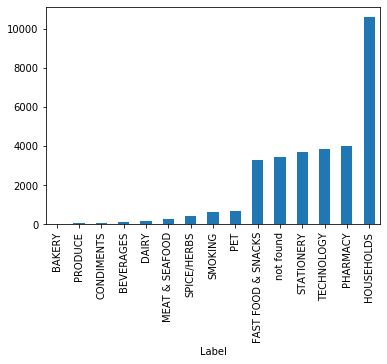

In [346]:
LabelDGMCount= DrugGM.groupby('Label').count()

LabelDGMCount.BRAND.sort_values().plot.bar()

In [347]:
DrugGM[DrugGM['Label'] == 'not found'].head(60)

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT,Label
180,32392,69,DRUG GM,Private,FIRST AID PRODUCTS,LINAMENTS,32 OZ,not found
415,40650,69,DRUG GM,Private,FEMININE HYGIENE,FEM HYGN DOUCHES,4.5 OZ,not found
455,41708,69,DRUG GM,Private,FIRST AID PRODUCTS,LINAMENTS,16 OZ,not found
477,42111,69,DRUG GM,Private,FEMININE HYGIENE,FEM HYGN DOUCHES,4.5 OZ,not found
586,44542,69,DRUG GM,Private,FIRST AID PRODUCTS,LINAMENTS,16 OZ,not found
691,47237,1411,DRUG GM,National,HOSIERY/SOCKS,NO-NONSENSE,,not found
706,47813,69,DRUG GM,Private,ANTACIDS,ANTI-ACIDS,30 CT,not found
1417,78059,206,DRUG GM,National,ANTACIDS,ANTI-ACIDS,,not found
1599,85340,751,DRUG GM,National,FEMININE HYGIENE,FEM. HYGN. TAMPONS,18 CT,not found
1773,92368,524,DRUG GM,National,FIREWORKS,AGE RESTRICTED FIREWORKS,6 CT,not found


**C. ALL THE OTHER SHOPS: PRODUCE, NUTRITION, COSMETICS etc.**

Since all these other shops are specialized the labels are easy to infer. Indeed it corresponds to the shop specialization.

In [349]:
# we standardize some labels for the seek of the vizualization
MEAT = product[product['DEPARTMENT'] == 'MEAT']
MEAT_PCKGD = product[product['DEPARTMENT'] == 'MEAT-PCKGD']
SEAFOOD = product[product['DEPARTMENT'] == 'SEAFOOD']
SEAFOOD_PCKGD = product[product['DEPARTMENT'] == 'SEAFOOD-PCKGD']
FROZEN_GROCERY = product[product['DEPARTMENT'] == 'FROZEN GROCERY']

MEAT['Label'] = 'MEAT & SEAFOOD'
MEAT_PCKGD['Label'] = 'MEAT & SEAFOOD'
SEAFOOD['Label'] = 'MEAT & SEAFOOD'
SEAFOOD_PCKGD['Label'] = 'MEAT & SEAFOOD'
FROZEN_GROCERY['Label'] = 'FROZEN'

/Users/lou/anaconda3/envs/ada/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/lou/anaconda3/envs/ada/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/lou/anaconda3/envs/ada/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [364]:
product['Label'] = product['DEPARTMENT']

product.Label[product['DEPARTMENT'] == 'GROCERY'] = Grocery.Label
product.Label[product['DEPARTMENT'] == 'MEAT'] = MEAT.Label
product.Label[product['DEPARTMENT'] == 'MEAT-PCKGD'] = MEAT_PCKGD.Label

MEAT['Label'] = 'MEAT & SEAFOOD'
MEAT_PCKGD['Label'] = 'MEAT & SEAFOOD'
SEAFOOD['Label'] = 'MEAT & SEAFOOD'
SEAFOOD_PCKGD['Label'] = 'MEAT & SEAFOOD'
FROZEN_GROCERY['Label'] = 'FROZEN'

/Users/lou/anaconda3/envs/ada/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [365]:
product.head()

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT,Label
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB,FROZEN
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,,MISC. TRANS.
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,,PASTRY
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ,PRODUCE
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ,FAST FOOD & SNACKS


In [363]:
product[product['DEPARTMENT'] == 'GROCERY'].Label.head()

0    GROCERY
3    GROCERY
4    GROCERY
5    GROCERY
6    GROCERY
Name: Label, dtype: object